<a href="https://colab.research.google.com/github/4d5645/StatsForDataAnalysis_MIPT/blob/main/Practice_of_building_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice of building regression
Let's analyze the survey data of 4361 women from Botswana.


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

In [6]:
print(np.__version__)
print(pd.__version__)
print(sc.__version__)
print(statsmodels.__version__)

1.21.5
1.3.5
1.4.1
0.10.2


In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We know about each of them:
- how many children did she have (sign ceb)
- age
- duration of education (educ)
- religious affiliation (religion)
- ideal, in her opinion, the number of children in the family (idlnchld)
- has she ever been married (evermarr)
- age of first marriage (agefm)
- duration of education of the husband (heduc)
- does she know about contraceptive methods (knowmeth)
- does she use contraceptive methods (usemeth)
- does she live in the city (urban)
- does she have electricity, radio, TV and bicycle (electric, radio, tv, bicycle)

Let's learn how to estimate the number of ceb children by other features.

## Data loading and processing

In [2]:
!pip install -U patsy

In [198]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/botswana.tsv', sep='\t')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [199]:
data

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,0,16,7,protestant,2.0,1.0,0.0,0,NaN,NaN,0,0.0,1.0,0.0,0.0
4357,2,28,7,protestant,4.0,1.0,1.0,0,NaN,NaN,0,0.0,1.0,0.0,0.0
4358,4,24,5,protestant,4.0,1.0,1.0,0,NaN,NaN,0,0.0,1.0,0.0,0.0
4359,1,26,0,spirit,5.0,1.0,0.0,1,22.0,7.0,0,0.0,1.0,0.0,0.0


In [200]:
len(data['religion'].unique())

4

In [201]:
data['nevermarr'] = 0
for count, value in enumerate(data['agefm'].isna()):
  if value == True:
    data['nevermarr'][count] = 1
  else:
    data['nevermarr'][count] = 0

data.drop('evermarr', axis=1, inplace=True)
data

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,0,16,7,protestant,2.0,1.0,0.0,NaN,NaN,0,0.0,1.0,0.0,0.0,1
4357,2,28,7,protestant,4.0,1.0,1.0,NaN,NaN,0,0.0,1.0,0.0,0.0,1
4358,4,24,5,protestant,4.0,1.0,1.0,NaN,NaN,0,0.0,1.0,0.0,0.0,1
4359,1,26,0,spirit,5.0,1.0,0.0,22.0,7.0,0,0.0,1.0,0.0,0.0,0


In [202]:
data['nevermarr'].unique()

array([1, 0])

In [203]:
data['agefm'].replace(NaN, 0, inplace=True)

In [204]:
data

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,0,16,7,protestant,2.0,1.0,0.0,0.0,NaN,0,0.0,1.0,0.0,0.0,1
4357,2,28,7,protestant,4.0,1.0,1.0,0.0,NaN,0,0.0,1.0,0.0,0.0,1
4358,4,24,5,protestant,4.0,1.0,1.0,0.0,NaN,0,0.0,1.0,0.0,0.0,1
4359,1,26,0,spirit,5.0,1.0,0.0,22.0,7.0,0,0.0,1.0,0.0,0.0,0


In [205]:
for count, value in enumerate(data['heduc'].isna()):
  if value == True:
    if data['nevermarr'][count] == 1:
      data['heduc'][count] = -1

In [206]:
data

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,0,16,7,protestant,2.0,1.0,0.0,0.0,-1.0,0,0.0,1.0,0.0,0.0,1
4357,2,28,7,protestant,4.0,1.0,1.0,0.0,-1.0,0,0.0,1.0,0.0,0.0,1
4358,4,24,5,protestant,4.0,1.0,1.0,0.0,-1.0,0,0.0,1.0,0.0,0.0,1
4359,1,26,0,spirit,5.0,1.0,0.0,22.0,7.0,0,0.0,1.0,0.0,0.0,0


In [207]:
data['heduc'].isna().sum()

123

In [208]:
data['idlnchld_noans'] = 0
data.loc[data.idlnchld.isnull(), 'idlnchld_noans'] = 1
data['heduc_noans'] = 0
data.loc[data.heduc.isnull(), 'heduc_noans'] = 1
data['usemeth_noans'] = 0
data.loc[data.usemeth.isnull(), 'usemeth_noans'] = 1
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0,0,0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0,0,0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0,0,0,0


In [209]:
data.idlnchld[data.idlnchld.isnull()] = -1
data.heduc[data.heduc.isnull()] = -2
data.usemeth[data.usemeth.isnull()] = -1

In [210]:
data

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0,0,0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0,0,0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,0,16,7,protestant,2.0,1.0,0.0,0.0,-1.0,0,0.0,1.0,0.0,0.0,1,0,0,0
4357,2,28,7,protestant,4.0,1.0,1.0,0.0,-1.0,0,0.0,1.0,0.0,0.0,1,0,0,0
4358,4,24,5,protestant,4.0,1.0,1.0,0.0,-1.0,0,0.0,1.0,0.0,0.0,1,0,0,0
4359,1,26,0,spirit,5.0,1.0,0.0,22.0,7.0,0,0.0,1.0,0.0,0.0,0,0,0,0


## Building a regression of the number of ceb children on all available features 
(using the smf.ols method)


In [211]:
m1 = smf.ols('ceb ~ age + educ + religion + idlnchld + knowmeth + usemeth +'\
                    'agefm + heduc + urban + electric + radio + tv + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans', 
             data=data)
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:13:36   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

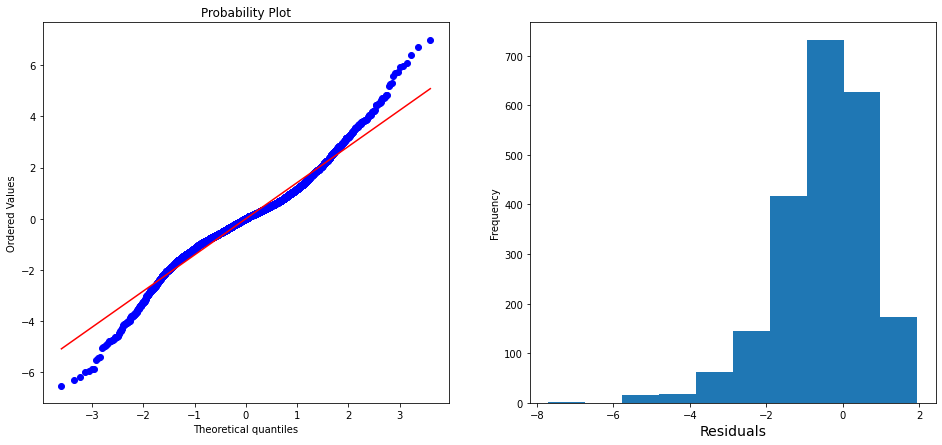

In [212]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Checking by the Broisch-Pagan criterion the homoscedasticity of the error in the constructed model:

In [214]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


The error is heteroscedastic.
We remove insignificant signs of religion, radio and tv from the model. We check the homoscedasticity of the error, if necessary, we make White's correction.


In [215]:
m2 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + usemeth +'\
                    'agefm + heduc + urban + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans', data=data)
fitted = m2.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.7
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:13:37   Log-Likelihood:                -7735.7
No. Observations:                4349   AIC:                         1.550e+04
Df Residuals:                    4334   BIC:                         1.560e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

In [216]:
print("F=%f, p=%f, k1=%f" % m1.fit().compare_f_test(m2.fit()))

F=0.767320, p=0.595562, k1=6.000000


We remove from the current model usemeth_noans and usemeth. We check the hypothesis that the quality of the model has not deteriorated using the Fisher criterion.


In [217]:
m3 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth +'\
                    'agefm + heduc + urban + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans', data=data)
fitted = m3.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     611.7
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:17:10   Log-Likelihood:                -7827.0
No. Observations:                4349   AIC:                         1.568e+04
Df Residuals:                    4336   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1932      0.202     -5.

In [219]:
print(m2.fit().compare_f_test(m3.fit()))

(92.91524538041648, 3.0801200123445724e-40, 2.0)
